# Going Deeper 
## [G-04] Augmentation

> ## 목차
---

### 1. 프로젝트 개요
    1. 1 요약
    1. 2 루브릭 평가 기준
### 2. 프로젝트
    2. 1 ResNet 기본 블록 구성하기
    2. 2 ResNet-34, ResNet-50 Complete Model
    2. 3 일반 네트워크(plain network) 만들기
    2. 4 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
### 3. 결론

> ## 1. 프로젝트 개요
---

> ### 1.1 요약

Augmentation의 기법 믹스업이나 컷믹스를 사용하면 컴퓨터가 훈련할 때 여러가지 특징들을 더 생각하게 되기 때문에 더 좋은 데이터를 얻을 수 있을 것이다.

> ### 1.2 루브릭 평가 기준

|평가문항|상세기준|
|---|---|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

> ## 2. 프로젝트
---

> ### 2. 1 데이터 불러오기

In [2]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import tensorflow_datasets as tfds

print('=3')

=3


In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete36ZCOK/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete36ZCOK/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


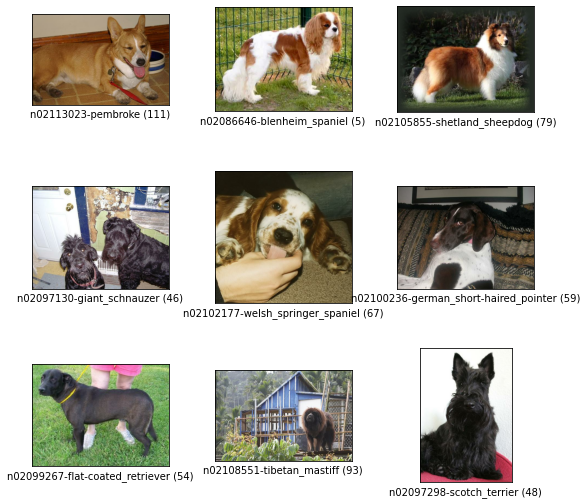

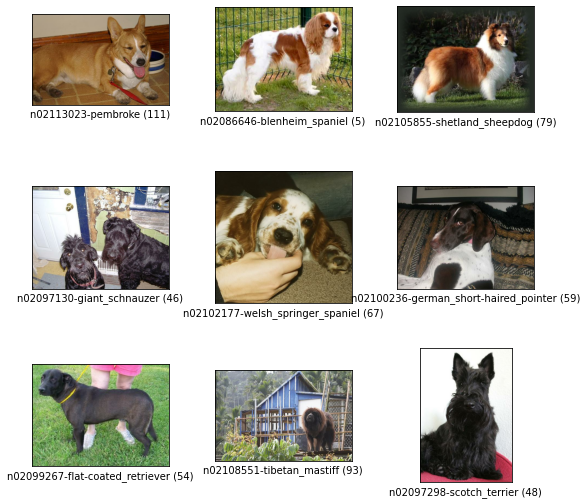

In [5]:
tfds.show_examples(ds_train, ds_info)

> ### 2. 2 Augumentation을 적용한 데이터셋 만들기

In [6]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):

    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):

    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [7]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [8]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# def onehot(image,label):
#     image = tf.clip_by_value(image, 0, 1)
#     return image, label

def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)

        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


> ### 2. 3 모델 만들기


In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=True,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=True,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


102981632/102967424 [==============================] - 1s 0us/step


In [10]:

mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=True,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')

])

cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=True,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')

])
print('=3')

=3


In [10]:
mixup_aug_resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_2 (Dense)             (None, 120)               120120    
                                                                 
Total params: 25,756,832
Trainable params: 25,703,712
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True,with_cutmix=False) # augmentation
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=False,with_mixup=True) # mixup 추가 및 augmentation
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False,with_cutmix=True) # cutmix 추가 및 augmentation
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


> ### 2. 4 모델 훈련하기

In [12]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20
BATCH_SIZE = 16

In [14]:

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 97s 121ms/step - loss: 4.7849 - accuracy: 0.0218 - val_loss: 4.7833 - val_accuracy: 0.0366
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 4.7756 - accuracy: 0.0786 - val_loss: 4.7686 - val_accuracy: 0.1376
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 4.7625 - accuracy: 0.1723 - val_loss: 4.7529 - val_accuracy: 0.2170
Epoch 4/20
750/750 [==============================] - 94s 126ms/step - loss: 4.7452 - accuracy: 0.2378 - val_loss: 4.7343 - val_accuracy: 0.2811
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 4.7245 - accuracy: 0.2928 - val_loss: 4.7135 - val_accuracy: 0.3104
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 4.7004 - accuracy: 0.3276 - val_loss: 4.6891 - val_accuracy: 0.3380
Epoch 7/20
750/750 [==============================] - 94s 126ms/step - loss: 4.6712 - accuracy: 0.3543 - val_loss: 4.6629 - val_ac

In [15]:
# Augmentation

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 96s 120ms/step - loss: 4.7857 - accuracy: 0.0175 - val_loss: 4.7859 - val_accuracy: 0.0126
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 4.7771 - accuracy: 0.0648 - val_loss: 4.7665 - val_accuracy: 0.1463
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 4.7634 - accuracy: 0.1558 - val_loss: 4.7494 - val_accuracy: 0.2430
Epoch 4/20
750/750 [==============================] - 94s 126ms/step - loss: 4.7460 - accuracy: 0.2489 - val_loss: 4.7283 - val_accuracy: 0.3281
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 4.7246 - accuracy: 0.3109 - val_loss: 4.7034 - val_accuracy: 0.3714
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 4.7002 - accuracy: 0.3521 - val_loss: 4.6771 - val_accuracy: 0.4045
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 4.6712 - accuracy: 0.3787 - val_loss: 4.6467 - val_ac

In [16]:
# Augumentation & mixup

mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)
history_resnet50_aug_mixup = mixup_aug_resnet50.fit(
    ds_train_aug_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 97s 121ms/step - loss: 4.7875 - accuracy: 0.0056 - val_loss: 4.7878 - val_accuracy: 0.0091
Epoch 2/20
750/750 [==============================] - 93s 125ms/step - loss: 4.7855 - accuracy: 0.0115 - val_loss: 4.7810 - val_accuracy: 0.0293
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 4.7830 - accuracy: 0.0288 - val_loss: 4.7747 - val_accuracy: 0.0656
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 4.7793 - accuracy: 0.0535 - val_loss: 4.7671 - val_accuracy: 0.0985
Epoch 5/20
750/750 [==============================] - 92s 122ms/step - loss: 4.7741 - accuracy: 0.0835 - val_loss: 4.7574 - val_accuracy: 0.1419
Epoch 6/20
750/750 [==============================] - 92s 123ms/step - loss: 4.7676 - accuracy: 0.1185 - val_loss: 4.7456 - val_accuracy: 0.1832
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 4.7608 - accuracy: 0.1428 - val_loss: 4.7331 - val_ac

In [17]:
#Augumentation & cutmix

cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = cutmix_aug_resnet50.fit(
    ds_train_aug_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 126ms/step - loss: 4.7864 - accuracy: 0.0109 - val_loss: 4.7871 - val_accuracy: 0.0106
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 4.7845 - accuracy: 0.0253 - val_loss: 4.7773 - val_accuracy: 0.0569
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 4.7820 - accuracy: 0.0439 - val_loss: 4.7709 - val_accuracy: 0.0962
Epoch 4/20
750/750 [==============================] - 92s 123ms/step - loss: 4.7788 - accuracy: 0.0697 - val_loss: 4.7637 - val_accuracy: 0.1580
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 4.7750 - accuracy: 0.1079 - val_loss: 4.7550 - val_accuracy: 0.2017
Epoch 6/20
750/750 [==============================] - 92s 123ms/step - loss: 4.7697 - accuracy: 0.1373 - val_loss: 4.7453 - val_accuracy: 0.2762
Epoch 7/20
750/750 [==============================] - 95s 127ms/step - loss: 4.7647 - accuracy: 0.1743 - val_loss: 4.7342 - val_a

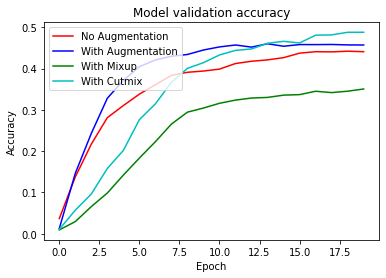

In [18]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'c')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Mixup', 'With Cutmix'], loc='upper left')
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
# plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

> ## 결론
---

예상했던 결과는 컷믹스와 믹스업의 경우가 가장 높은 정확도를 갖고 나머지는 augmentation, 그리고 원본 파일일 것으로 예상했는데 예상외로  
믹스업을 한 데이터가 값이 제대로 안나왔다...   
